# Analyse des données de Bornes de Recharges, avec exploration des données et description des élements intéressants.

## Import des librairies/infos Drive

In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
#from dbfread import DBF
from os import listdir
from os.path import isfile, join
from shapely import line_merge, MultiLineString
from shapely.geometry import Point, MultiPoint
from shapely.geometry import Polygon, MultiPolygon
import os
import missingno as msno
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#pip install geopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
Chemin_Donnees : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/"

In [ ]:
path = Chemin_Donnees + "Bornes_recharge/consolidation-etalab-schema-irve-statique-v-2.3.1-20250105.csv"  # Mettre le chemin du fichier dans le path


borne_csv = pd.read_csv(path)


<ipython-input-5-80df96376ede>:4: DtypeWarning: Columns (12,18,19,20,21,22,23,24,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  borne_csv = pd.read_csv(path)


## Infos sur le fichier présent sur le site du Projet

Dans le but de constituer un répertoire national des Infrastructures de recharge pour véhicules électriques (IRVE), ouvert et accessible à tous, les collectivités locales porteuses d’un projet d’installation d’IRVE doivent, au fur et à mesure de la mise en service des stations, publier sur la plateforme data.gouv.fr les données statiques relatives à la localisation et aux caractéristiques techniques de ces installations selon les modalités définies dans l’arrêté du 4 mai 2021.
L'équipe data.gouv.fr consolide l'ensemble des jeux de données produits par les différents acteurs territoriaux sur un jeu de donnée consolidé. Celui-ci a pour objectif d'être le plus exhaustif possible et ambitionne de regrouper l'ensemble des bornes IRVE françaises.


Ce CSV donne des informations sur les différents points de charges (PDC) présents sur le territoire français. Il ne référence donc pas les différents sites de recharges (stations) mais ils peuvent être trouvés via les coordonnées ou d'autres infos (comme les noms ou ID de stations, les adresses etc...). Il faut savoir que plusieurs points de charges peuvent êtres présents au sein d'une même station (regroupement) et que un pdc peut contenir 1 à plusieurs prises de charges. Il faut savoir que les différentes prises d'un pdc ont la même valeur dans la variable id_pdc_itinerance mais cela n'est pas clair car cela reviendrait à contredire le fait que une ligne équivaut à un pdc... De plus la variable id_pdc_itinerance n'est pas référencée tout le temps dans nos données.

Pour cause de simplification, nous pouvons partir du postulat que une ligne correspond à un PDC, qui lui correspond à une prise, car il n'y a aucune information dans nos données qui indiquent le nombre de prise dans le pdc en question.

## Etude Descriptive

In [ ]:
borne_csv.head()

nom_amenageur  siren_amenageur           contact_amenageur  \
0  SOLVEO ENERGIES      508886132.0  bornes@solveo-energies.com   
1  SOLVEO ENERGIES      508886132.0  bornes@solveo-energies.com   
2  SOLVEO ENERGIES      508886132.0  bornes@solveo-energies.com   
3  SOLVEO ENERGIES      508886132.0  bornes@solveo-energies.com   
4  SOLVEO ENERGIES      508886132.0  bornes@solveo-energies.com   

     nom_operateur           contact_operateur telephone_operateur  \
0  SOLVEO ENERGIES  bornes@solveo-energies.com      05 32 98 01 58   
1  SOLVEO ENERGIES  bornes@solveo-energies.com      05 32 98 01 58   
2  SOLVEO ENERGIES  bornes@solveo-energies.com      05 32 98 01 58   
3  SOLVEO ENERGIES  bornes@solveo-energies.com      05 32 98 01 58   
4  SOLVEO ENERGIES  bornes@solveo-energies.com      05 32 98 01 58   

      nom_enseigne id_station_itinerance id_station_local      nom_station  \
0  SOLVEO ENERGIES         DKMONE3785539              NaN  Golf de Garonne   
1  SOLVEO ENERGIES         DKMONE3785539              NaN  Golf de Garonne   
2  SOLVEO ENERGIES         DKMONE3785539              NaN  Golf de Garonne   
3  SOLVEO ENERGIES         DKMONE3785539              NaN  Golf de Garonne   
4  SOLVEO ENERGIES         DKMONE3785539              NaN  Golf de Garonne   

   ...       datagouv_dataset_id                  datagouv_resource_id  \
0  ...  6763fb30168ecaa13a086b0c  a9352425-5392-4028-b02d-fcc88b856a0e   
1  ...  6763fb30168ecaa13a086b0c  a9352425-5392-4028-b02d-fcc88b856a0e   
2  ...  6763fb30168ecaa13a086b0c  a9352425-5392-4028-b02d-fcc88b856a0e   
3  ...  6763fb30168ecaa13a086b0c  a9352425-5392-4028-b02d-fcc88b856a0e   
4  ...  6763fb30168ecaa13a086b0c  a9352425-5392-4028-b02d-fcc88b856a0e   

  datagouv_organization_or_owner                        created_at  \
0                solveo-energies  2024-12-19T10:53:36.428000+00:00   
1                solveo-energies  2024-12-19T10:53:36.428000+00:00   
2                solveo-energies  2024-12-19T10:53:36.428000+00:00   
3                solveo-energies  2024-12-19T10:53:36.428000+00:00   
4                solveo-energies  2024-12-19T10:53:36.428000+00:00   

   consolidated_longitude consolidated_latitude consolidated_code_postal  \
0                1.407644             43.628261                      NaN   
1                1.407644             43.628261                      NaN   
2                1.407644             43.628261                      NaN   
3                1.407644             43.628261                      NaN   
4                1.407644             43.628261                      NaN   

   consolidated_commune consolidated_is_lon_lat_correct  \
0              Toulouse                            True   
1              Toulouse                            True   
2              Toulouse                            True   
3              Toulouse                            True   
4              Toulouse                            True   

  consolidated_is_code_insee_verified  
0                                True  
1                                True  
2                                True  
3                                True  
4                                True  

[5 rows x 51 columns]

### Codes de compréhension de colonnes

In [ ]:
borne_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119500 entries, 0 to 119499
Data columns (total 51 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   nom_amenageur                        117705 non-null  object 
 1   siren_amenageur                      48611 non-null   float64
 2   contact_amenageur                    59996 non-null   object 
 3   nom_operateur                        116118 non-null  object 
 4   contact_operateur                    119500 non-null  object 
 5   telephone_operateur                  80864 non-null   object 
 6   nom_enseigne                         119500 non-null  object 
 7   id_station_itinerance                119500 non-null  object 
 8   id_station_local                     76269 non-null   object 
 9   nom_station                          119500 non-null  object 
 10  implantation_station                 119500 non-null  object 
 11  adresse_stati

pdl  = Point de Livraison Electricité

In [ ]:
borne_csv["id_station_itinerance"].value_counts()

id_station_itinerance
Non concerné          1133
FRSAEPMAD              505
FRSAEPSA               350
FRSAEPPDA              241
FRP07E59350009         146
                      ... 
FRLMSE1000101740         1
FRLMSE1000101739         1
FRLMSE1000100988         1
FRLMSE1000100987         1
FRMAPP000000006998       1
Name: count, Length: 49370, dtype: int64

In [ ]:
borne_csv["id_station_local"].value_counts()

id_station_local
FRSAEPMAD           505
FRSAEPSA            350
FRSAEPPDA           241
1035738              68
1278694              64
                   ... 
FRIOYE407802          1
FRIOYE405353          1
FRIOYE405352          1
FRIOYE405351          1
FRWBCERCG0C21101      1
Name: count, Length: 35527, dtype: int64

il y n'y a pas de valeurs unique (ou pertinent) sur cet identifiant donc le plus simple serait de créer une colonne id globale.

In [ ]:
borne_csv["id_pdc_itinerance"].value_counts()

id_pdc_itinerance
Non concerné        115
FRA68P680210015       4
FREBNEWJYE1           2
FRFR1EPJXS3           2
FREBNEWBSP1           2
                   ... 
FRLDLE00002060        1
FRLDLE00002059        1
FRLDLE00002058        1
FRLDLE00002057        1
FROTHEIZIG233371      1
Name: count, Length: 110061, dtype: int64

In [ ]:
borne_csv["nom_station"].value_counts()

nom_station
SAEMES | Parking Madeleine-Tronchet                505
SAEMES | Parking Saint-Augustin                    350
SAEMES | Parking Porte d'Auteuil                   241
LILLE - Euralille Centre Commercial                146
Airbus ADS - Toulouse                              104
                                                  ... 
ChargeGuru/d19ca123-838b-4ed3-9fdf-488195fa1f75      1
ChargeGuru/f150d43a-ea95-45c6-879c-4e5ea7265515      1
ChargeGuru/b711549b-7802-4ef5-8cb0-88fee984bd06      1
ChargeGuru/95c42b3c-e121-4c9d-a5f2-2ba4436eee0b      1
SAFEXIS                                              1
Name: count, Length: 32129, dtype: int64

In [ ]:
borne_csv["nbre_pdc"].value_counts()

nbre_pdc
2      35992
1      15967
4      10343
6       8552
3       7291
       ...  
50        50
45        45
76        39
54        12
352        1
Name: count, Length: 69, dtype: int64

In [ ]:
borne_csv["coordonneesXY"].value_counts()

coordonneesXY
[2.324200757103425, 48.871139475303686]     505
[2.320074840507427, 48.87579799849022]      350
[2.2561617253619675, 48.847266326997016]    241
[0.64889, 46.46231]                         172
[6.22003, 49.4122]                          154
                                           ... 
[0.8226861, 48.31978104]                      1
[0.818359, 48.322194]                         1
[0.80373021, 48.32166905]                     1
[1.356077, 48.7207]                           1
[2.138365,49.045084]                          1
Name: count, Length: 31334, dtype: int64

In [ ]:
borne_csv["nbre_pdc"].value_counts()

nbre_pdc
2      35992
1      15967
4      10343
6       8552
3       7291
       ...  
50        50
45        45
76        39
54        12
352        1
Name: count, Length: 69, dtype: int64

Recherche colonne doublons

In [ ]:
doublons = borne_csv.duplicated()
doublons.value_counts()

False    119500
Name: count, dtype: int64

Il n'y a pas de doublons dans le tableau

### Données manquantes :

<Axes: >

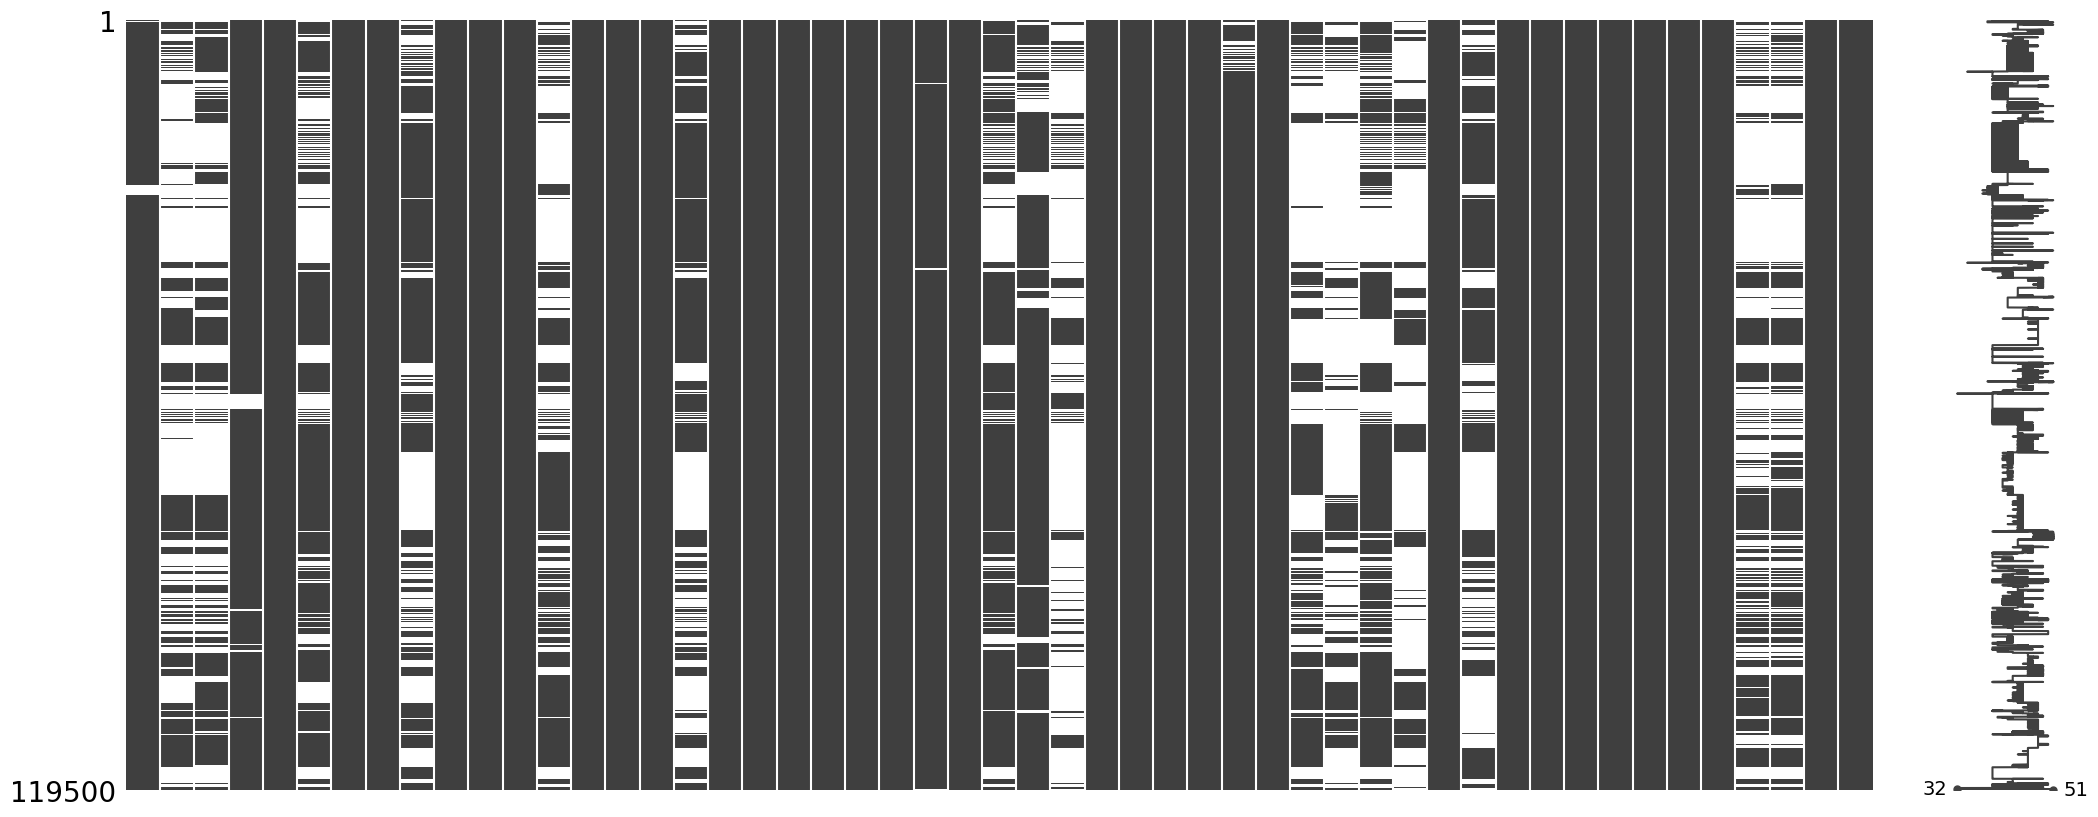

In [ ]:
msno.matrix(borne_csv)

On voit qu'il y a de nombreuses variables avec des valeurs manquantes, on essaye de voir quelles sont elles

In [ ]:
pourcentage_nulles = borne_csv.isnull().mean() * 100

print(pourcentage_nulles)

nom_amenageur                           1.506786
siren_amenageur                        59.270558
contact_amenageur                      49.702929
nom_operateur                           2.840455
contact_operateur                       0.000000
telephone_operateur                    32.164377
nom_enseigne                            0.000000
id_station_itinerance                   0.000000
id_station_local                       36.314131
nom_station                             0.000000
implantation_station                    0.000000
adresse_station                         0.000000
code_insee_commune                      0.000000
coordonneesXY                           0.000000
nbre_pdc                                0.000000
id_pdc_itinerance                       0.000000
id_pdc_local                           37.587294
puissance_nominale                      0.000000
prise_type_ef                           0.000000
prise_type_2                            0.000000
prise_type_combo_ccs

Il y a de nombreuses colonnes qui ont beaucoup de valeurs vides comme le code postal, la commune, les tarifications, moyens de paiement et autres.

Ces colonnes ne sont donc pas exploitables, en ce qui concerne les informations sur les départements, géographie etc... il faut se référer au coordonnées qui elles sont tout le temps la

### Recherche de valeurs abberantes (nbre_pdc)

nbre pdc  ==  le nombre de pdc dans la station correspondante.

In [ ]:
max(borne_csv["nbre_pdc"])

505

In [ ]:
borne_csv[borne_csv["nbre_pdc"] == 505]

nom_amenageur  siren_amenageur    contact_amenageur  \
98246        SAEMES      317032993.0  g.geffroy@saemes.fr   
98247        SAEMES      317032993.0  g.geffroy@saemes.fr   
98248        SAEMES      317032993.0  g.geffroy@saemes.fr   
98249        SAEMES      317032993.0  g.geffroy@saemes.fr   
98250        SAEMES      317032993.0  g.geffroy@saemes.fr   
...             ...              ...                  ...   
98746        SAEMES      317032993.0  g.geffroy@saemes.fr   
98747        SAEMES      317032993.0  g.geffroy@saemes.fr   
98748        SAEMES      317032993.0  g.geffroy@saemes.fr   
98749        SAEMES      317032993.0  g.geffroy@saemes.fr   
98750        SAEMES      317032993.0  g.geffroy@saemes.fr   

                        nom_operateur  \
98246  TotalEnergies Marketing France   
98247  TotalEnergies Marketing France   
98248  TotalEnergies Marketing France   
98249  TotalEnergies Marketing France   
98250  TotalEnergies Marketing France   
...                               ...   
98746  TotalEnergies Marketing France   
98747  TotalEnergies Marketing France   
98748  TotalEnergies Marketing France   
98749  TotalEnergies Marketing France   
98750  TotalEnergies Marketing France   

                             contact_operateur telephone_operateur  \
98246  supervision-ev.france@totalenergies.com          0483568009   
98247  supervision-ev.france@totalenergies.com          0483568009   
98248  supervision-ev.france@totalenergies.com          0483568009   
98249  supervision-ev.france@totalenergies.com          0483568009   
98250  supervision-ev.france@totalenergies.com          0483568009   
...                                        ...                 ...   
98746  supervision-ev.france@totalenergies.com          0483568009   
98747  supervision-ev.france@totalenergies.com          0483568009   
98748  supervision-ev.france@totalenergies.com          0483568009   
98749  supervision-ev.france@totalenergies.com          0483568009   
98750  supervision-ev.france@totalenergies.com          0483568009   

      nom_enseigne id_station_itinerance id_station_local  \
98246       SAEMES             FRSAEPMAD        FRSAEPMAD   
98247       SAEMES             FRSAEPMAD        FRSAEPMAD   
98248       SAEMES             FRSAEPMAD        FRSAEPMAD   
98249       SAEMES             FRSAEPMAD        FRSAEPMAD   
98250       SAEMES             FRSAEPMAD        FRSAEPMAD   
...            ...                   ...              ...   
98746       SAEMES             FRSAEPMAD        FRSAEPMAD   
98747       SAEMES             FRSAEPMAD        FRSAEPMAD   
98748       SAEMES             FRSAEPMAD        FRSAEPMAD   
98749       SAEMES             FRSAEPMAD        FRSAEPMAD   
98750       SAEMES             FRSAEPMAD        FRSAEPMAD   

                               nom_station  ...       datagouv_dataset_id  \
98246  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98247  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98248  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98249  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98250  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
...                                    ...  ...                       ...   
98746  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98747  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98748  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98749  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   
98750  SAEMES | Parking Madeleine-Tronchet  ...  614d936841a4ffe70f20286e   

                       datagouv_resource_id  datagouv_organization_or_owner  \
98246  31814552-ad42-410d-8b4d-82d114f2de59  totalenergies-marketing-france   
98247  31814552-ad42-410d-8b4d-82d114f2de59  totalenergies-marketing-france   
98248  31814552-ad42-410d-8b4d-82d114f2de59 

Le max de pdc dans une station est de 505. Après une recherche, c'est en effet le cas donc on ne considère pas qu'il y ai des valeurs abberantes dans cette variable.

  

### Changements de variables/Suppression/Création variables

Changement de format en str pour les codes INSEE des pdc

In [ ]:
#borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].fillna(0).astype(int)
borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].astype(str)
#borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].replace("0", np.nan)
borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].str.split('.').str[0]
borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].replace("nan", None)
borne_csv["code_insee_commune"] = borne_csv["code_insee_commune"].astype(str)

Dates de mise en service :  

In [ ]:
borne_csv['date_mise_en_service'] = pd.to_datetime(borne_csv['date_mise_en_service'], errors='coerce')

In [ ]:
max(borne_csv['date_mise_en_service'])

Timestamp('2025-06-06 00:00:00')

In [ ]:
min(borne_csv['date_mise_en_service'])

Timestamp('1930-01-22 00:00:00')

Dans nos données il y a donc des point de recharge qui datent de mai 2025 ou de 1930, il y a donc en plus de l'absence de données des problèmes de données aberrantes sur les dates de points de recharge. A savoir si ces problèmes concernent uniquement les dates ou si le pdc est lui même unitilisable.

In [ ]:
borne_csv[borne_csv['date_mise_en_service'] == '1930-01-22']["adresse_station"]

107409    158 Rue des Epinettes 73290 La Motte-Servolex
107410    158 Rue des Epinettes 73290 La Motte-Servolex
Name: adresse_station, dtype: object

In [ ]:
borne_csv[borne_csv['date_mise_en_service'] == '2000-01-01']["adresse_station"]

92801     Place Georges Lamour
92803     Place Georges Lamour
92827        Rue Adrien Regent
92829        Rue Adrien Regent
92830    Proximité médiathèque
92831    Proximité médiathèque
Name: adresse_station, dtype: object

D'après une recherche, il y a bien deux bornes de recharges, c'est seulement un problème de date, il faut donc identifier de quel ampleur est cet incident de dates.


In [ ]:
df_sorted = borne_csv.sort_values(by='date_mise_en_service')

In [ ]:
df_sorted.head(50)["date_mise_en_service"]

107409   1930-01-22
107410   1930-01-22
92801    2000-01-01
92803    2000-01-01
92829    2000-01-01
92830    2000-01-01
92831    2000-01-01
92827    2000-01-01
44938    2002-10-04
81968    2012-11-17
81965    2012-11-17
81964    2012-11-17
81963    2012-11-17
81962    2012-11-17
81967    2012-11-17
81966    2012-11-17
81969    2012-11-17
799      2013-02-01
800      2013-02-01
797      2013-02-01
801      2013-02-01
802      2013-02-01
805      2013-02-01
798      2013-02-01
818      2013-02-01
807      2013-02-01
790      2013-02-01
808      2013-02-01
811      2013-02-01
812      2013-02-01
816      2013-02-01
806      2013-02-01
789      2013-02-01
817      2013-02-01
819      2013-02-01
820      2013-02-01
821      2013-02-01
876      2013-02-01
877      2013-02-01
100355   2013-07-22
100356   2013-07-22
92297    2014-03-18
92295    2014-03-18
100229   2014-04-22
100228   2014-04-22
100230   2014-04-22
100231   2014-04-22
100236   2014-04-22
100237   2014-04-22
92308    2014-06-30
Name: date_mise_en_service, dtype: datetime64[ns]

On décide donc de mettre en valeurs manquantes toutes les dates de bornes en dessous de 2012.

In [ ]:
borne_csv.loc[borne_csv['date_mise_en_service'] < '2012-01-01', 'date_mise_en_service'] = pd.NaT

In [ ]:
df_sorted = borne_csv.sort_values(by='date_mise_en_service')
df_sorted.head(50)["date_mise_en_service"]

81968    2012-11-17
81966    2012-11-17
81965    2012-11-17
81964    2012-11-17
81962    2012-11-17
81963    2012-11-17
81967    2012-11-17
81969    2012-11-17
806      2013-02-01
820      2013-02-01
799      2013-02-01
789      2013-02-01
798      2013-02-01
877      2013-02-01
800      2013-02-01
819      2013-02-01
818      2013-02-01
876      2013-02-01
817      2013-02-01
790      2013-02-01
801      2013-02-01
797      2013-02-01
805      2013-02-01
816      2013-02-01
821      2013-02-01
807      2013-02-01
808      2013-02-01
811      2013-02-01
812      2013-02-01
802      2013-02-01
100356   2013-07-22
100355   2013-07-22
92297    2014-03-18
92295    2014-03-18
100237   2014-04-22
100236   2014-04-22
100231   2014-04-22
100230   2014-04-22
100228   2014-04-22
100229   2014-04-22
92309    2014-06-30
92308    2014-06-30
108871   2014-07-04
108869   2014-07-04
108868   2014-07-04
108874   2014-07-04
108872   2014-07-04
108873   2014-07-04
108870   2014-07-04
108875   2014-07-04
Name: date_mise_en_service, dtype: datetime64[ns]

On traite maintenant les valeurs de dates qui sen trouvent en dehors de nôtre période d'étude

In [ ]:
df_sorted2 = borne_csv.sort_values(by='date_mise_en_service', ascending=False)
df_sorted2.head(50)["date_mise_en_service"]

55740   2025-06-06
55741   2025-06-06
55742   2025-06-06
55743   2025-06-06
55739   2025-06-06
14087   2025-01-03
14095   2025-01-03
14094   2025-01-03
14093   2025-01-03
14092   2025-01-03
14089   2025-01-03
14088   2025-01-03
14085   2025-01-03
14086   2025-01-03
14097   2025-01-03
14084   2025-01-03
14083   2025-01-03
14082   2025-01-03
14105   2025-01-03
14096   2025-01-03
14104   2025-01-03
14098   2025-01-03
14101   2025-01-03
14100   2025-01-03
14099   2025-01-03
3913    2025-01-01
11302   2025-01-01
11300   2025-01-01
3911    2025-01-01
3912    2025-01-01
3914    2025-01-01
45965   2024-12-30
45966   2024-12-30
45967   2024-12-30
45968   2024-12-30
45969   2024-12-30
45970   2024-12-30
13190   2024-12-27
7946    2024-12-27
13187   2024-12-27
13188   2024-12-27
13189   2024-12-27
13191   2024-12-27
13192   2024-12-27
13193   2024-12-27
7947    2024-12-27
15708   2024-12-27
15707   2024-12-27
15706   2024-12-27
15705   2024-12-27
Name: date_mise_en_service, dtype: datetime64[ns]

In [ ]:
borne_csv[borne_csv['date_mise_en_service'] == '2025-06-06']["coordonneesXY"]

55739    [0.10508242127821,46.959612206534]
55740    [0.10508242127821,46.959612206534]
55741    [0.10510934575294,46.959551828622]
55742    [0.10510934575294,46.959551828622]
55743    [0.10507339980252,46.959646041768]
Name: coordonneesXY, dtype: object

D'après une recherche sur ces coordonnées, les points de recharge sont bel et bien mis à disposition, donc il faut mettre des valeurs nulles dans ces lignes.

In [ ]:
borne_csv.loc[borne_csv['date_mise_en_service'] > '2025-01-04', 'date_mise_en_service'] = pd.NaT

In [ ]:
print(min(borne_csv['date_mise_en_service']))
print(max(borne_csv['date_mise_en_service']))

2012-11-17 00:00:00
2025-01-03 00:00:00


C'est bon les données de dates sont mieux. Le seul problème étant le nombre de valeurs manquantes, que pouvons faire afin de régler ce problème ?

coordonneesXY :     

In [ ]:
type(borne_csv["coordonneesXY"].values[0])

str

Il faut convertir cette variables en array/liste de deux valeurs

In [ ]:
borne_csv["coordonneesXY"].values

array(['[1.407644, 43.628261]', '[1.407644, 43.628261]',
       '[1.407644, 43.628261]', ..., '[4.97,45.73]',
       '[2.8066202,46.1815093]', '[2.138365,49.045084]'], dtype=object)

In [ ]:
borne_csv['coordonneesXY'] = borne_csv['coordonneesXY'].apply(ast.literal_eval)

In [ ]:
borne_csv["coordonneesXY"].values[:20]

array([list([1.407644, 43.628261]), list([1.407644, 43.628261]),
       list([1.407644, 43.628261]), list([1.407644, 43.628261]),
       list([1.407644, 43.628261]), list([1.407644, 43.628261]),
       list([1.407644, 43.628261]), list([1.407644, 43.628261]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084]),
       list([-0.056488, 48.723084]), list([-0.056488, 48.723084])],
      dtype=object)

Aussi, on s'aperçcoit que les données sont dits "a l'envers", on les trouvent au format longitude latitude. Il faut vérifier ou sont situés les bornes dites "extremes" et voir si il faut les supprimer ou non des données.

In [ ]:
premieres_valeurs = borne_csv['coordonneesXY'].apply(lambda x: x[0]).tolist()
dernieres_valeurs = borne_csv['coordonneesXY'].apply(lambda x: x[1]).tolist()
borne_csv['coord_long'] = premieres_valeurs
borne_csv['coord_lat'] = dernieres_valeurs
print(min(premieres_valeurs), max(premieres_valeurs))
print(min(dernieres_valeurs), max(dernieres_valeurs))

-149.905377 55.7659
-21.3723 61.520355206093384


In [ ]:
borne_csv[borne_csv['coord_long'] == -149.905377]

nom_amenageur  siren_amenageur contact_amenageur  \
29667  Moorea, Salvastore              NaN               NaN   
29668  Moorea, Salvastore              NaN               NaN   

            nom_operateur      contact_operateur telephone_operateur  \
29667  Freshmile | FR*FR1  roaming@freshmile.com                 NaN   
29668  Freshmile | FR*FR1  roaming@freshmile.com                 NaN   

           nom_enseigne      id_station_itinerance id_station_local  \
29667  Freshmile France  FRFR1P2402436309874874020           694271   
29668  Freshmile France  FRFR1P2402436309874874020           694271   

                       nom_station  ... datagouv_organization_or_owner  \
29667  Freshmile France/MBSSYTGNDB  ...                       gireve-2   
29668  Freshmile France/MBSSYTGNDB  ...                       gireve-2   

                             created_at consolidated_longitude  \
29667  2023-03-24T14:32:54.036000+00:00            -149.905377   
29668  2023-03-24T14:32:54.036000+00:00            -149.905377   

      consolidated_latitude  consolidated_code_postal consolidated_commune  \
29667            -17.527631                       NaN                  NaN   
29668            -17.527631                       NaN                  NaN   

      consolidated_is_lon_lat_correct  consolidated_is_code_insee_verified  \
29667                           False                                False   
29668                           False                                False   

       coord_long  coord_lat  
29667 -149.905377 -17.527631  
29668 -149.905377 -17.527631  

[2 rows x 53 columns]

In [ ]:
borne_csv[borne_csv['coord_long'] == 55.7659]

nom_amenageur  siren_amenageur contact_amenageur       nom_operateur  \
30559  Total Réunion              NaN               NaN  Freshmile | FR*FR1   
35351  Total Réunion              NaN               NaN  Freshmile | FR*FR1   

           contact_operateur telephone_operateur      nom_enseigne  \
30559  roaming@freshmile.com                 NaN  Freshmile France   
35351  roaming@freshmile.com                 NaN  Freshmile France   

           id_station_itinerance id_station_local  \
30559  FRFR1P5206752614426705835           160293   
35351  FRFR1P5206752614426705835           160293   

                          nom_station  ... datagouv_organization_or_owner  \
30559  Freshmile France/stphilipreuni  ...                       gireve-2   
35351  Freshmile France/stphilipreuni  ...                       gireve-2   

                             created_at consolidated_longitude  \
30559  2023-03-24T14:32:54.036000+00:00                55.7659   
35351  2023-03-24T14:32:54.036000+00:00                55.7659   

      consolidated_latitude  consolidated_code_postal consolidated_commune  \
30559              -21.3598                       NaN                  NaN   
35351              -21.3598                       NaN                  NaN   

      consolidated_is_lon_lat_correct  consolidated_is_code_insee_verified  \
30559                           False                                False   
35351                           False                                False   

      coord_long coord_lat  
30559    55.7659  -21.3598  
35351    55.7659  -21.3598  

[2 rows x 53 columns]

In [ ]:
borne_csv[borne_csv['coord_lat'] == 61.520355206093384]

nom_amenageur  siren_amenageur          contact_amenageur  \
10317  CHROMA COULEURS      921931267.0  chroma.couleurs@gmail.com   

      nom_operateur    contact_operateur telephone_operateur     nom_enseigne  \
10317      CAR2PLUG  contact@car2plug.fr          0988991011  CHROMA COULEURS   

      id_station_itinerance id_station_local      nom_station  ...  \
10317           FRC2P008001      FRC2P008001  CHROMA COULEURS  ...   

      datagouv_organization_or_owner                        created_at  \
10317                       car2plug  2024-05-02T13:41:41.826000+00:00   

      consolidated_longitude consolidated_latitude  consolidated_code_postal  \
10317              16.248664             61.520355                   97142.0   

      consolidated_commune consolidated_is_lon_lat_correct  \
10317           Les Abymes                           False   

       consolidated_is_code_insee_verified coord_long  coord_lat  
10317                                 True  16.248664  61.520355  

[1 rows x 53 columns]

Après vérification des min et max des valeurs de longitudes et latitudes, on obtient de valeurs a priori abberantes mais qui ne le sont pas vraiment (DOM TOM) mais aussi des valeurs réellement abberantes (point en Suède par exemple). Afin de faciliter l'étude, il est préférable de réaliser l'étude sur la france métropolitaine.

On affine donc nos données sur uniquement la France métropolitaine à partir de valeurs min et max de longitudes et latitudes.

In [ ]:
bornes_long = [-5.14 , 9.56]
bornes_lat = [41.33 , 51.1]

borne_csv = borne_csv[(borne_csv['coord_long'] >= bornes_long[0]) & (borne_csv['coord_long'] <= bornes_long[1])]
borne_csv = borne_csv[(borne_csv['coord_lat'] >= bornes_lat[0]) & (borne_csv['coord_lat'] <= bornes_lat[1])]

In [ ]:
# Vérification des bornes appliquées
premieres_valeurs = borne_csv['coordonneesXY'].apply(lambda x: x[0]).tolist()
dernieres_valeurs = borne_csv['coordonneesXY'].apply(lambda x: x[1]).tolist()
borne_csv['coord_long'] = premieres_valeurs
borne_csv['coord_lat'] = dernieres_valeurs
print(min(premieres_valeurs), max(premieres_valeurs))
print(min(dernieres_valeurs), max(dernieres_valeurs))

-5.097226 9.553642
41.390111 51.063125


In [ ]:
borne_csv[borne_csv['coord_long'] == 9.553642]

nom_amenageur  siren_amenageur contact_amenageur  \
30345  Domaine de Riva Bella              NaN               NaN   
30346  Domaine de Riva Bella              NaN               NaN   

            nom_operateur      contact_operateur telephone_operateur  \
30345  Freshmile | FR*FR1  roaming@freshmile.com                 NaN   
30346  Freshmile | FR*FR1  roaming@freshmile.com                 NaN   

           nom_enseigne      id_station_itinerance id_station_local  \
30345  Freshmile France  FRFR1P1582392646077560060           559694   
30346  Freshmile France  FRFR1P1582392646077560060           559694   

                       nom_station  ... datagouv_organization_or_owner  \
30345  Freshmile France/DS2ZKBGWPN  ...                       gireve-2   
30346  Freshmile France/DS2ZKBGWPN  ...                       gireve-2   

                             created_at consolidated_longitude  \
30345  2023-03-24T14:32:54.036000+00:00               9.553642   
30346  2023-03-24T14:32:54.036000+00:00               9.553642   

      consolidated_latitude  consolidated_code_postal consolidated_commune  \
30345             42.156857                       NaN                  NaN   
30346             42.156857                       NaN                  NaN   

      consolidated_is_lon_lat_correct  consolidated_is_code_insee_verified  \
30345                           False                                False   
30346                           False                                False   

      coord_long  coord_lat  
30345   9.553642  42.156857  
30346   9.553642  42.156857  

[2 rows x 53 columns]

In [ ]:
borne_csv[borne_csv['coord_lat'] == 51.063125]

nom_amenageur  siren_amenageur    contact_amenageur nom_operateur  \
14511       DRIVECO              NaN  support@driveco.com       DRIVECO   
14512       DRIVECO              NaN  support@driveco.com       DRIVECO   
14806       DRIVECO              NaN  support@driveco.com       DRIVECO   
14807       DRIVECO              NaN  support@driveco.com       DRIVECO   

         contact_operateur telephone_operateur nom_enseigne  \
14511  support@driveco.com                 NaN      DRIVECO   
14512  support@driveco.com                 NaN      DRIVECO   
14806  support@driveco.com                 NaN      DRIVECO   
14807  support@driveco.com                 NaN      DRIVECO   

      id_station_itinerance id_station_local                    nom_station  \
14511    FRDRVPCRFMKT591231              NaN  Carrefour Market - Bray-Dunes   
14512    FRDRVPCRFMKT591231              NaN  Carrefour Market - Bray-Dunes   
14806    FRDRVPCRFMKT591231              NaN  Carrefour Market - Bray-Dunes   
14807    FRDRVPCRFMKT591231              NaN  Carrefour Market - Bray-Dunes   

       ... datagouv_organization_or_owner                        created_at  \
14511  ...                        driveco  2024-12-09T16:29:47.755000+00:00   
14512  ...                        driveco  2024-12-09T16:29:47.755000+00:00   
14806  ...                        driveco  2024-12-09T16:29:47.755000+00:00   
14807  ...                        driveco  2024-12-09T16:29:47.755000+00:00   

      consolidated_longitude consolidated_latitude  consolidated_code_postal  \
14511               2.521164             51.063125                   59123.0   
14512               2.521164             51.063125                   59123.0   
14806               2.521164             51.063125                   59123.0   
14807               2.521164             51.063125                   59123.0   

      consolidated_commune consolidated_is_lon_lat_correct  \
14511           Bray-Dunes                            True   
14512           Bray-Dunes                            True   
14806           Bray-Dunes                            True   
14807           Bray-Dunes                            True   

       consolidated_is_code_insee_verified coord_long  coord_lat  
14511                                 True   2.521164  51.063125  
14512                                 True   2.521164  51.063125  
14806                                 True   2.521164  51.063125  
14807                                 True   2.521164  51.063125  

[4 rows x 53 columns]

Après vérifications, on obtient bien uniquement des bornes de recharges présentes en France métropolitaine

Variables intéressantes dans le cadre du projet et leur % de valeurs manquantes : (Au premier abord)   
 - coordonneesXY 0%
 - adresse station ? 0% mais les départements 7%
 - nbre_pdc   0%
 - type de prise/accès/tarif ? (paiement bcp de % mais 0 pour les accès)
 - date_mise_en_service 31%

On essaye de retirer le code postal et donc le numéro de département des adresses

In [ ]:
def extraire_code_postal(adresse):
    # Utilisation d'une expression régulière pour trouver un code postal
    match = re.search(r'\b\d{5}\b', adresse)
    if match:
        return match.group(0)  # Retourne le code postal trouvé
    return None  # Si aucun code postal trouvé

# Appliquer la fonction à la colonne 'Adresse' pour créer une nouvelle colonne 'CodePostal'
borne_csv['CodePostal'] = borne_csv['adresse_station'].apply(extraire_code_postal)

In [ ]:
borne_csv['CodePostal'].value_counts()

CodePostal
75008    1149
75016     597
31000     536
75010     505
06000     410
         ... 
30160       1
33075       1
94366       1
57990       1
20172       1
Name: count, Length: 5318, dtype: int64

In [ ]:
for i in borne_csv[borne_csv['CodePostal'] == "75008"]["adresse_station"].values :
  print(i)

10 Rue François 1er, 75008 Paris
10 Rue François 1er, 75008 Paris
10 Rue François 1er, 75008 Paris
10 Rue François 1er, 75008 Paris
12 Rue François 1er, 75008 Paris
12 Rue François 1er, 75008 Paris
24 Rue François 1er, 75008 Paris
24 Rue François 1er, 75008 Paris
24 Rue François 1er, 75008 Paris
24 Rue François 1er, 75008 Paris
45/47 AVENUE FRANKLIN ROOSEVELT, 75008 PARIS
45/47 AVENUE FRANKLIN ROOSEVELT, 75008 PARIS
45/47 AVENUE FRANKLIN ROOSEVELT, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
43Bis BOULEVARD DES BATIGNOLLES, 75008 PARIS
18 Avenue Hoche, 75008 PARIS
18 Avenue Hoche, 75008 PARIS
18 Avenue Hoche, 75008 PARIS
18 Avenue Hoche, 75008 PARIS
18 Avenue Hoch

A premier abord, les résultats de cette recherche semble étonnante au vu du grand nombre de mêmes adresses mais après des recherches plus poussés cela parait logique (notamment pour 21 place de la Madeleine, 75008 Paris).

In [ ]:
def extraire_departement(code_postal):
    if code_postal:
        return code_postal[:2]  # Les deux premiers chiffres
    return None



# Appliquer la fonction pour extraire le numéro de département
borne_csv['Departement'] = borne_csv['CodePostal'].apply(extraire_departement)
#borne_csv['Departement'] = borne_csv['Departement'].astype(int)

In [ ]:
pourcentage_vide = borne_csv['Departement'].isna().mean() * 100
pourcentage_vide

7.30282784990966

In [ ]:
for i in borne_csv['Departement'].value_counts().index :
  print(i)

75
59
13
33
31
92
06
44
77
78
83
57
38
62
69
34
74
94
93
67
14
49
76
91
95
26
29
63
73
42
60
54
35
21
84
30
17
37
56
64
41
85
40
22
51
68
80
11
50
88
45
25
89
66
86
03
01
10
71
07
28
24
79
27
05
02
72
47
81
18
16
19
87
82
20
61
04
65
53
12
52
58
43
08
46
32
39
90
55
09
36
70
15
23
48


Il n'y a pas de valeurs abberantes


Création d'une colonne contenant la région de la station d'ou provient le point de recharge.

In [ ]:
# Dictionnaire contenant pour chaques numéros de département la région correspondante
departements_regions = {
    # Auvergne-Rhône-Alpes
    '01': 'Auvergne-Rhône-Alpes', '03': 'Auvergne-Rhône-Alpes', '07': 'Auvergne-Rhône-Alpes',
    '15': 'Auvergne-Rhône-Alpes', '26': 'Auvergne-Rhône-Alpes', '38': 'Auvergne-Rhône-Alpes',
    '42': 'Auvergne-Rhône-Alpes', '43': 'Auvergne-Rhône-Alpes', '63': 'Auvergne-Rhône-Alpes',
    '69': 'Auvergne-Rhône-Alpes', '73': 'Auvergne-Rhône-Alpes', '74': 'Auvergne-Rhône-Alpes',

    # Bourgogne-Franche-Comté
    '21': 'Bourgogne-Franche-Comté', '25': 'Bourgogne-Franche-Comté', '39': 'Bourgogne-Franche-Comté',
    '58': 'Bourgogne-Franche-Comté', '70': 'Bourgogne-Franche-Comté', '71': 'Bourgogne-Franche-Comté',
    '89': 'Bourgogne-Franche-Comté', '90': 'Bourgogne-Franche-Comté',

    # Bretagne
    '22': 'Bretagne', '29': 'Bretagne', '35': 'Bretagne', '56': 'Bretagne',

    # Centre-Val de Loire
    '18': 'Centre-Val de Loire', '28': 'Centre-Val de Loire', '36': 'Centre-Val de Loire',
    '37': 'Centre-Val de Loire', '41': 'Centre-Val de Loire', '45': 'Centre-Val de Loire',

    # Corse
     '20': 'Corse',

    # Grand Est
    '08': 'Grand Est', '10': 'Grand Est', '51': 'Grand Est', '52': 'Grand Est', '54': 'Grand Est',
    '55': 'Grand Est', '57': 'Grand Est', '67': 'Grand Est', '68': 'Grand Est', '88': 'Grand Est',

    # Hauts-de-France
    '02': 'Hauts-de-France', '59': 'Hauts-de-France', '60': 'Hauts-de-France',
    '62': 'Hauts-de-France', '80': 'Hauts-de-France',

    # Île-de-France
    '75': 'Île-de-France', '77': 'Île-de-France', '78': 'Île-de-France', '91': 'Île-de-France',
    '92': 'Île-de-France', '93': 'Île-de-France', '94': 'Île-de-France', '95': 'Île-de-France',

    # Normandie
    '14': 'Normandie', '27': 'Normandie', '50': 'Normandie', '61': 'Normandie', '76': 'Normandie',

    # Nouvelle-Aquitaine
    '16': 'Nouvelle-Aquitaine', '17': 'Nouvelle-Aquitaine', '19': 'Nouvelle-Aquitaine',
    '23': 'Nouvelle-Aquitaine', '24': 'Nouvelle-Aquitaine', '33': 'Nouvelle-Aquitaine',
    '40': 'Nouvelle-Aquitaine', '47': 'Nouvelle-Aquitaine', '64': 'Nouvelle-Aquitaine',
    '79': 'Nouvelle-Aquitaine', '86': 'Nouvelle-Aquitaine', '87': 'Nouvelle-Aquitaine',

    # Occitanie
    '09': 'Occitanie', '11': 'Occitanie', '12': 'Occitanie', '30': 'Occitanie', '31': 'Occitanie',
    '32': 'Occitanie', '34': 'Occitanie', '46': 'Occitanie', '48': 'Occitanie', '65': 'Occitanie',
    '66': 'Occitanie', '81': 'Occitanie', '82': 'Occitanie',

    # Pays de la Loire
    '44': 'Pays de la Loire', '49': 'Pays de la Loire', '53': 'Pays de la Loire',
    '72': 'Pays de la Loire', '85': 'Pays de la Loire',

    # Provence-Alpes-Côte d'Azur
    '04': 'Provence-Alpes-Côte d\'Azur', '05': 'Provence-Alpes-Côte d\'Azur',
    '06': 'Provence-Alpes-Côte d\'Azur', '13': 'Provence-Alpes-Côte d\'Azur',
    '83': 'Provence-Alpes-Côte d\'Azur', '84': 'Provence-Alpes-Côte d\'Azur',

    # Outre-mer
    '971': 'Guadeloupe', '972': 'Martinique', '973': 'Guyane', '974': 'La Réunion', '976': 'Mayotte'
}


In [ ]:
borne_csv['Region'] = borne_csv['Departement'].map(departements_regions)

In [ ]:
borne_csv['Region'].value_counts()

Region
Île-de-France                 19457
Auvergne-Rhône-Alpes          14580
Occitanie                     10777
Nouvelle-Aquitaine            10752
Provence-Alpes-Côte d'Azur    10245
Grand Est                      9764
Hauts-de-France                8984
Pays de la Loire               6196
Normandie                      5168
Bretagne                       4741
Bourgogne-Franche-Comté        4691
Centre-Val de Loire            4459
Corse                           491
Name: count, dtype: int64

Création d'une colonne année de création

In [ ]:
borne_csv['Annee'] = borne_csv['date_mise_en_service'].dt.year

In [ ]:
borne_csv['Annee'].value_counts()

Annee
2023.0    22530
2024.0    20625
2022.0    16959
2021.0    11084
2020.0     4804
2019.0     1787
2017.0     1764
2016.0     1045
2018.0      735
2015.0      279
2014.0      150
2025.0       26
2013.0       24
2012.0        8
Name: count, dtype: int64

Récupération dans une colonne spéciale du code insee à partir des codes postaux.

In [ ]:
print(Chemin_Donnees)

/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/


Variables forcéments remplises :      
 - contact_operateur
 - nom_enseigne
 - id_station_itinerance
 - nom_station
 - implantation_station
 - adresse_station
 - coordonneesXY
 - nbre_pdc
 - id_pdc_itinerance
 - puissnace_nominale
 - prise_type_ef
 - prise_type_2
 - prise_type_combo_ccs
 - prise_type_chademo
 - prise_type_autre
 - paiement_acte
 - condition_acces
 - les accès...

### Analyse Descriptive/Graphiques

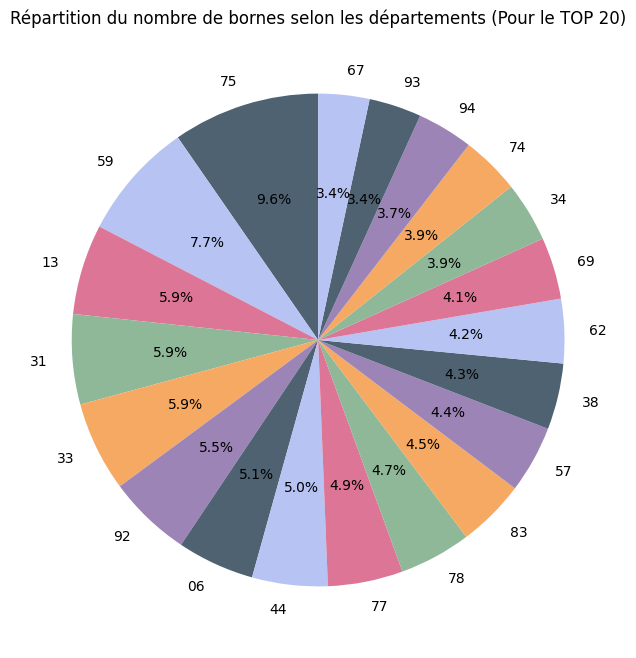

In [ ]:
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#F5A962', '#9D84B7']

plt.figure(figsize=(8, 8))
plt.pie(
    borne_csv['Departement'].value_counts()[:20].values,
    labels=borne_csv['Departement'].value_counts()[:20].index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title("Répartition du nombre de bornes selon les départements (Pour le TOP 20)")
plt.show()

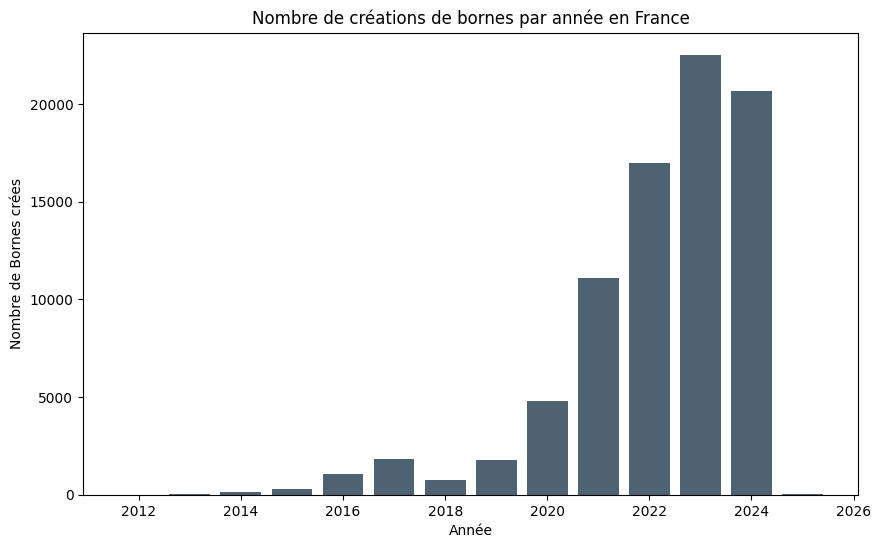

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
res = borne_csv['Annee'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(res.index, res.values, color='#4F6272')
plt.xlabel('Année')
plt.ylabel('Nombre de Bornes crées')
plt.title('Nombre de créations de bornes par année en France')
plt.show()
plt

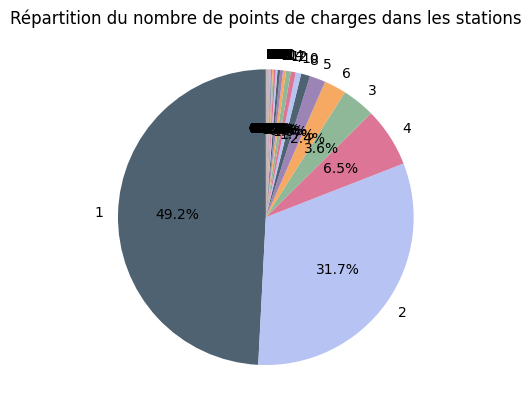

In [ ]:
plt.pie(
    tab2.value_counts(),
    labels = tab2.value_counts().index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title("Répartition du nombre de points de charges dans les stations")
plt.show()

### Création variable code INSEE via fichier GeoJson

In [ ]:
path_json : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/Autres données/communes.geojson"

gdf = gpd.read_file(path_json)

In [ ]:
gdf.head()

code          nom                                           geometry
0  03252   Saint-Pont  POLYGON ((3.26205 46.16463, 3.2639 46.16695, 3...
1  05039   Aubessagne  POLYGON ((6.03282 44.71293, 6.03339 44.71395, ...
2  16203      Mainzac  POLYGON ((0.46574 45.53962, 0.46431 45.54032, ...
3  16372  Souffrignac  POLYGON ((0.49858 45.56477, 0.49624 45.56569, ...
4  24002       Agonac  POLYGON ((0.68751 45.30032, 0.69055 45.30082, ...

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


# Implémentation des codes insee via les information de localisation fournis par nos données de bornes et les localisations de communes


# Étape 1 : Convertir les coordonnées des points en objets Point (nécessite longitude, latitude dans cet ordre)
borne_csv['geometry'] = borne_csv.apply(lambda row: Point(row['coord_long'], row['coord_lat']), axis=1)

# Étape 2 : Transformer points_df en GeoDataFrame
points_gdf = gpd.GeoDataFrame(borne_csv, geometry='geometry', crs=gdf.crs)  # Assurer que le CRS est le même

# Étape 3 : Effectuer une jointure spatiale pour trouver les communes correspondant aux points
points_with_insee = gpd.sjoin(points_gdf, gdf, how="left", predicate="within")

# Résultat : points_with_insee contient les points et leur code INSEE
print(points_with_insee["code"])


0         31555
1         31555
2         31555
3         31555
4         31555
          ...  
119495    2A345
119496    92050
119497    69271
119498    63233
119499    95572
Name: code, Length: 118995, dtype: object


In [ ]:
points_with_insee["code"] = points_with_insee["code"].astype(str) # Changement de format

Maintenant on compare les codes résulats avec ceux données dans le tableau de base : (grâce aux coordonnées de bornes et comparaison des deux résultat si différnents via recherche internet)

In [ ]:
borne_csv["coordonneesXY"].values[112098]

[2.2899947, 48.8794622]

In [ ]:
print(points_with_insee["code"].values[79247])
print(borne_csv["code_insee_commune"].values[79247])
print(borne_csv["coordonneesXY"].values[79247])

43051
51322
[4.33102, 45.06697]


In [ ]:
print(type(points_with_insee["code"].values[95313]))
print(type(borne_csv["code_insee_commune"].values[95313]))
print(borne_csv["coordonneesXY"].values[95313])

<class 'str'>
<class 'str'>
[2.139607906, 43.927570343]


In [ ]:
borne_csv["code_insee_commune"].values[:500]

array(['31555', '31555', '31555', '31555', '31555', '31555', '31555',
       '31555', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
      

In [ ]:
liste = []
for i in range(len(points_with_insee["code"].values)):
  #print(i)
  #print(points_with_insee["code"].values[i][:2])
  #print(type(borne_csv["code_insee_commune"].values[i]))#[:2]
  #print(borne_csv["code_insee_commune"].values[i])
  if not(borne_csv["code_insee_commune"].values[i]) == "None" :

      if points_with_insee["code"].values[i][:2] != borne_csv["code_insee_commune"].values[i][:2] :

          print(i)
          liste.append(i)
          #print(points_with_insee["code"].values[i])
          #print(borne_csv["code_insee_commune"].values[i])
          #print("borne_csv["coordonneesXY"].values[i]")


406
407
591
592
593
2150
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2418
2419
2420
2421
2422
4573
4575
4577
4579
4601
4603
4613
4615
4617
4619
4621
4623
4874
4876
4882
4884
4956
4958
4960
4962
4964
4966
6182
6184
6202
6204
6254
6256
6290
6292
6306
6308
6338
6340
6577
6579
6581
6583
6625
6627
6641
6643
7171
7173
7183
7185
9068
9069
9230
9232
9234
9236
9281
9283
9285
9287
9289
9291
9293
9296
9297
9299
9301
9303
9305
9307
10165
10166
10187
10189
10236
10237
10238
10239
10292
10293
10296
10297
15289
15292
15293
15708
15709
26298
26299
26300
26301
26302
27903
27907
37320
37321
37322
37323
37324
37325
37326
37327
37337
37338
37339
38153
38154
38221
38222
38223
38224
38377
38378
39767
39768
39769
39770
39771
39772
39866
39913
40667
40668
40669
40670
42577
42579
42580
42588
42591
42593
42595
42597
42600
42601
42605
42606
42615
42616
42617
42618
42619
42621
42623
42628
42630
42633
42634
42651
42655
42657
42659
42660
42665
42669
42674
42675
42679
42681
42685


In [ ]:
len(liste)

750

In [ ]:
liste = []
for i in range(len(points_with_insee["code"].values)):
  #print(i)
  #print(points_with_insee["code"].values[i][:2])
  #print(type(borne_csv["code_insee_commune"].values[i]))#[:2]
  #print(borne_csv["code_insee_commune"].values[i])
  if not(borne_csv["code_insee_commune"].values[i]) == "None" :

      if points_with_insee["code"].values[i] != borne_csv["code_insee_commune"].values[i] :

          print(i)
          liste.append(i)
          #print(points_with_insee["code"].values[i])
          #print(borne_csv["code_insee_commune"].values[i])
          #print("borne_csv["coordonneesXY"].values[i]")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
71759
71760
71761
71762
71763
71764
71765
71766
71767
71768
71769
71770
71771
71772
71773
71774
71775
71776
71777
71778
71779
71780
71781
71782
71783
71784
71785
71786
71787
71788
71789
71790
71791
71792
71793
71794
71795
71796
71797
71798
71799
71800
71801
71802
71803
71804
71805
71806
71807
71808
71809
71810
71811
71812
71813
71814
71815
71816
71817
71818
71819
71820
71821
71822
71823
71824
71825
71826
71827
71828
71829
71830
71831
71832
71833
71834
71835
71836
71837
71838
71839
71840
71841
71842
71843
71844
71845
71846
71847
71848
71849
71850
71851
71852
71853
71854
71855
71856
71857
71858
71859
71860
71861
71862
71863
71864
71865
71866
71867
71868
71869
71870
71871
71872
71873
71874
71875
71876
71877
71878
71879
71880
71881
71882
71883
71884
71885
71886
71887
71888
71889
71890
71891
71892
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
71910
71911
7191

In [ ]:
len(liste)

8125

Débrief :     
 - une fois les code insee récupérés avec les coordonnées, on compare avec les variables présentes (56% soit 60000 pdc) des codes insee données de base
 - il y a 8125 codes différents et 750 codes différents dont les 2 premiers chiffres sont différents. Donc environ 7000 dont les 2 premiers chiffres sont les mêmes
 - quand les 2 chiffres sont les mêmes, il s'agit juste très souvent (quelques tests a la main des dizaines) de villes collés dont le pdc se situe entre. L'aménageur a choisi de prendre une ville mais les coordonnées ont pris l'autre au sens strict des coordonnées
 - quand les deux chiffres sont différents, tous les test indiquent que la personne qui a taper le code a la main se trompe

Conclusion, on peut rajouter cette colonne de code insee

In [ ]:
# On met la colonne dans le tableau des bornes
borne_csv["code_insee"] = points_with_insee["code"]
borne_csv["commune"] = points_with_insee["nom"]

In [ ]:
pourcentage_nulles = borne_csv.isnull().mean() * 100

print(pourcentage_nulles)

nom_amenageur                           1.506786
siren_amenageur                        59.270558
contact_amenageur                      49.702929
nom_operateur                           2.840455
contact_operateur                       0.000000
telephone_operateur                    32.164377
nom_enseigne                            0.000000
id_station_itinerance                   0.000000
id_station_local                       36.314131
nom_station                             0.000000
implantation_station                    0.000000
adresse_station                         0.000000
code_insee_commune                      0.000000
coordonneesXY                           0.000000
nbre_pdc                                0.000000
id_pdc_itinerance                       0.000000
id_pdc_local                           37.587294
puissance_nominale                      0.000000
prise_type_ef                           0.000000
prise_type_2                            0.000000
prise_type_combo_ccs

### Doublons (via la colonne id_pdc_itinerence)

Visualisation

In [ ]:
borne_csv["id_pdc_itinerance"].value_counts().head(9300)

id_pdc_itinerance
Non concerné       114
FRA68P680210015      4
FREBNEVYRC2          2
FREBNEVZHD1          2
FREBNEVZHD2          2
                  ... 
FREBNEMWSU1          2
FREBNEMWSU2          2
FREBNEMYMM2          2
FREBNEMYMM1          2
FREBNEMXXD2          2
Name: count, Length: 9300, dtype: int64

In [ ]:
print(borne_csv[borne_csv['id_pdc_itinerance'] == "FREBNEMWSU2"])#["adresse_station"].values

                         nom_amenageur  siren_amenageur contact_amenageur  \
19137  SYME05 - Hautes-Alpes accélérée              NaN               NaN   
19138                            SPBR1              NaN               NaN   

        nom_operateur        contact_operateur telephone_operateur  \
19137  SPBR1 | FR*EBN    roaming@freshmile.com                 NaN   
19138           SPBR1  contact@reseau-eborn.fr         33423100350   

       nom_enseigne id_station_itinerance id_station_local  \
19137  Réseau eborn      FREBNPCSEKWHVUFM           106931   
19138         eborn      FREBNPCSEKWHVUFM       CSEKWHVUFM   

                    nom_station  ... consolidated_is_code_insee_verified  \
19137   Réseau eborn/CSEKWHVUFM  ...                               False   
19138  Vars, Office de Tourisme  ...                               False   

      coord_long  coord_lat CodePostal  Departement  \
19137   6.689987  44.594376      05560           05   
19138   6.689987  44.594376    

In [ ]:
borne_csv[borne_csv['id_pdc_itinerance'] == "Non concerné"]["adresse_station"].values

array(['1 Rue des Biches, 74100 Ville-la-Grand',
       '1 Impasse de Recouvrance 17100 SAINTES',
       'Rue Jean Perrin 14440 Douvres-la-Délivrande',
       '13 Avenue Max Maurey 06160 Antibes',
       '12 Av. Fridingen 77100 Nanteuil-lès-Meaux France',
       '2 Rue de Finlande, 69124 Colombier-Saugnieu', "Rue de l'huilerie",
       '21 chemin du haut du trou martin', '2 RUE BRANLY 77400',
       '25 rue du May', '208B rue Nationale 57600',
       '58 rue de Grosbliederstroff - 57200 SARREGUEMINES',
       '13 Rue Lavoisier 77400 Lagny-sur-Marne',
       'Quai de Seine 77000 La Rochette', 'ZA LA BALORAIS',
       '6 Avenue André Dulin 17300',
       '4b Rue de l’Ancien Hopital 57200 Sarreguemines',
       'avenue de toulouse 31410', '5 rue Robert Estienne ',
       '5 AVENUE DES PRES 94260', 'allée du golf 57200',
       ' Av. Eugène Vernholes, Dourdan',
       '302 RUE DR PAUL VERMALE, 30160 BESSEGES',
       "3 Avenue de l'euro, 31150 Bruguières", 'Route de Saint Philibert',
     

On remarque en testant les id_pdc_itinérence que il y a beaucoup de pdc qui contiennent le même ID. A premier abord on pense que cela est normal car le id local est différent mais quand pour certains on regarde les bornes par recherche internet, on se rend compte que les points semblent être en double. (sauf pour le non concerné)

C'est pour cela que nous allons supprimer les lignes pour les ces id

In [ ]:
# On conserve les bornes ou l'itinerence est non concerné
df_non_concerne = borne_csv[borne_csv['id_pdc_itinerance'] == 'Non concerné']

# On supprime les doublons dans le reste du dataframe
df_without_duplicates = borne_csv[borne_csv['id_pdc_itinerance'] != 'Non concerné'].drop_duplicates(subset='id_pdc_itinerance')

# Concatenation
borne_csv = pd.concat([df_non_concerne, df_without_duplicates])


borne_csv = borne_csv.sort_index()  # Si tu veux restaurer l'ordre initial


print(borne_csv["id_pdc_itinerance"].value_counts())


id_pdc_itinerance
Non concerné       114
FRQPKEQPRK70181      1
FRQPKEQPRK70171      1
FRQPKEQPRK70161      1
FRQPKEQPRK70151      1
                  ... 
FRIOYE438571         1
FRIOYE438553         1
FRIOYE438552         1
FRIOYE438551         1
FRIOYE438653         1
Name: count, Length: 109567, dtype: int64


## Conclusion :      
 - il y des problèmes dans le remplissage des lignes, dans le sens ou des personnes ont remplis des lignes en pensant qu'il s'agissait de station ou de prise (pas sur pour celui la) Comment pouvons nous faire pour gérer cet incident ?

## Import du tableau nettoyé au format CSV :      

Il s'agit la de la première version nettoyée du jeu de données de bornes. Par la suite, certaines colonnes vont être ajoutés ou améliorer pour son utilisation dans le dashboard

In [ ]:
#borne_csv.to_csv("Bornes_nettoye.csv", index=False, sep=";")